In [1]:
import pandas as pd
import requests
import zipfile
import io
import os

# Download the zip file from Google Drive
url = 'https://drive.google.com/uc?export=download&id=1LiOAeu4r9EPflCuCTJUosCUO4gqGdBsI'

response = requests.get(url)

# Extract the zip file content directly from the response
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall()

# Load the data from the Excel files in the extracted directory
data_frames = {}
for root, dirs, files in os.walk('.'):
    for file_name in files:
        if file_name.endswith('.xlsx'):
            file_path = os.path.join(root, file_name)
            data_frames[file_name] = pd.read_excel(file_path)

In [2]:
# =========================
# Build result_df (normalize -> per-file means -> across-file mean & SD)
# =========================
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid", context="talk")

# Illusion columns expected in each sheet
illusions = ['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4']

scaler = MinMaxScaler()

per_file_means = []
for fname, df in data_frames.items():
    # require the needed columns
    if not set(illusions).issubset(df.columns) or \
       'Temporal Frequency' not in df.columns or 'Noise Size' not in df.columns:
        continue

    tmp = df.copy()

    # coerce to numeric to avoid hidden strings
    tmp[illusions] = tmp[illusions].apply(pd.to_numeric, errors='coerce')

    # normalize ratings WITHIN file to [0, 1]
    tmp[illusions] = scaler.fit_transform(tmp[illusions])

    # one row per (TF, Noise Size) in this file
    g = (tmp
         .groupby(['Temporal Frequency', 'Noise Size'], as_index=False, observed=True)[illusions]
         .mean())
    g['source'] = fname
    per_file_means.append(g)

if not per_file_means:
    raise ValueError("No Excel files contained the required columns to compute results.")

# stack all files
data_combined = pd.concat(per_file_means, ignore_index=True)

# across-file mean & SD for each TF x Noise Size
grouped = data_combined.groupby(['Temporal Frequency', 'Noise Size'], observed=True)
mean_df = grouped[illusions].mean().reset_index()
std_df  = grouped[illusions].std(ddof=1).reset_index()

# rename columns
mean_df = mean_df.rename(columns={c: f'{c} mean' for c in illusions})
std_df  = std_df.rename(columns={c: f'{c} std dev' for c in illusions})

# final table used for plotting
result_df = pd.merge(mean_df, std_df, on=['Temporal Frequency', 'Noise Size'], how='inner')

# keep a stable order for axes
tf_order = sorted(pd.unique(result_df['Temporal Frequency']))
ns_order = sorted(pd.unique(result_df['Noise Size']))


In [3]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20  # You can change the size to fit your needs

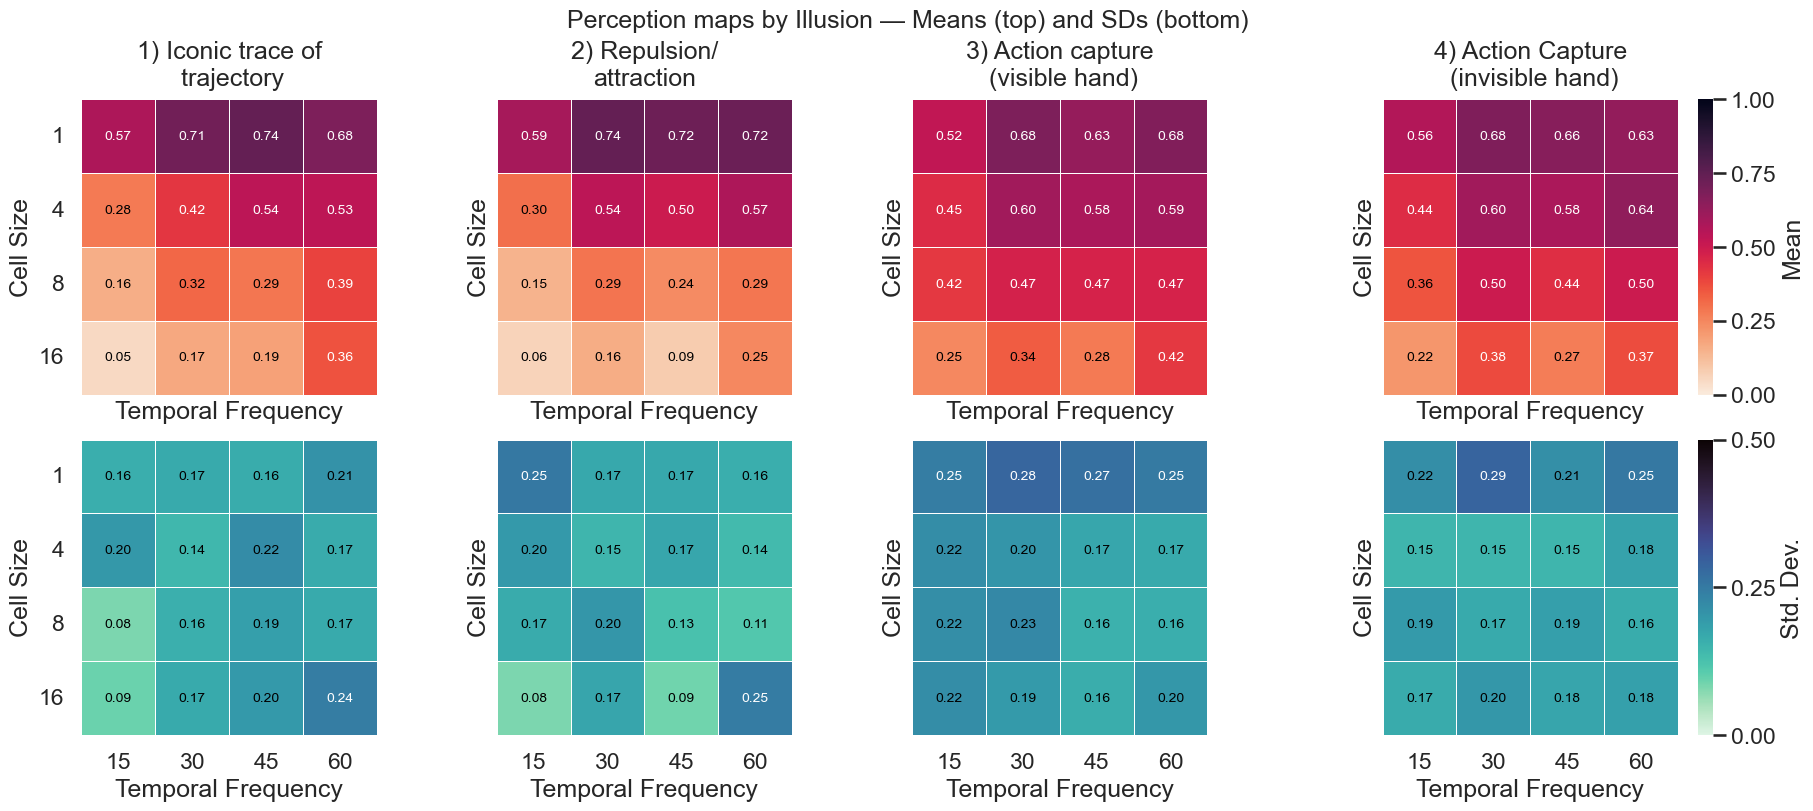

In [12]:
# =========================
# A) Heatmaps: Means (top) + SDs (bottom)  [constrained_layout]
# =========================
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors

ANNOTATE_VALUES = True          # <- turn on/off numbers in cells
ANNOTATE_FMT    = ".2f"         # <- number format (2 decimals)
MEAN_CMAP       = sns.color_palette("rocket_r", as_cmap=True)
SD_CMAP         = sns.color_palette("mako_r", as_cmap=True)

fig, axes = plt.subplots(
    2, 4, figsize=(18, 8),
    sharex='col', sharey='row',
    constrained_layout=True
)

titles = [
    '1) Iconic trace of\n trajectory',
    '2) Repulsion/\nattraction',
    '3) Action capture\n (visible hand)',
    '4) Action Capture\n (invisible hand)'
]

vmin_mean, vmax_mean = 0.0, 1.0
sd_cols = [f'{ill} std dev' for ill in illusions]
vmax_sd = float(np.nanmax(result_df[sd_cols].to_numpy()))
if not np.isfinite(vmax_sd) or vmax_sd <= 0:
    # fall back if SDs are all-zero/NaN — also prevents “all-white” colorbar
    vmax_sd = 0.20

def annotate_heatmap(ax, data_frame, vmin, vmax, fmt=".2f"):
    """Add per-cell values with automatic black/white text for contrast."""
    if data_frame is None:
        return
    arr = data_frame.to_numpy()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    nrows, ncols = arr.shape
    for i in range(nrows):
        for j in range(ncols):
            val = arr[i, j]
            if not np.isfinite(val):
                continue
            # choose text color by background lightness
            rgba = MEAN_CMAP(norm(val)) if ax in axes[0, :] else SD_CMAP(norm(val))
            # luminance heuristic: if background is dark, use white text
            lum = 0.2126 * rgba[0] + 0.7152 * rgba[1] + 0.0722 * rgba[2]
            txt_color = "white" if lum < 0.45 else "black"
            ax.text(j + 0.5, i + 0.5, format(val, fmt),
                    ha="center", va="center", fontsize=10, color=txt_color)

for i, ill in enumerate(illusions):
    mcol, scol = f'{ill} mean', f'{ill} std dev'

    mean_piv = (result_df
                .pivot_table(index='Noise Size', columns='Temporal Frequency',
                             values=mcol, aggfunc='mean', observed=True)
                .reindex(index=ns_order, columns=tf_order))

    sd_piv   = (result_df
                .pivot_table(index='Noise Size', columns='Temporal Frequency',
                             values=scol, aggfunc='mean', observed=True)
                .reindex(index=ns_order, columns=tf_order))

    # Means (top row)
    axm = axes[0, i]
    hm = sns.heatmap(
        mean_piv, ax=axm, cmap=MEAN_CMAP,
        vmin=vmin_mean, vmax=vmax_mean,
        cbar=(i == 3), cbar_kws={'label': 'Mean', 'ticks': [0, .25, .5, .75, 1]},
        linewidths=0.6, linecolor='white', square=True
    )
    # light gray for missing values (if any)
    axm.set_facecolor((0.95, 0.95, 0.95))
    # subtle contours to reveal shape without going 3D
    X, Y = np.meshgrid(tf_order, ns_order)
    Z = mean_piv.to_numpy()
    if np.isfinite(Z).any():
        axm.contour(X, Y, Z, levels=6, colors='k', linewidths=0.6, alpha=0.45)

    axm.set_title(titles[i], pad=10)
    axm.set_ylabel('Cell Size')
    axm.set_xlabel('Temporal Frequency')
    axm.set_xticklabels(tf_order)
    axm.set_yticklabels(ns_order, rotation=0)

    if ANNOTATE_VALUES:
        annotate_heatmap(axm, mean_piv, vmin_mean, vmax_mean, fmt=ANNOTATE_FMT)

    # SDs (bottom row)
    axs = axes[1, i]
    hs = sns.heatmap(
        sd_piv, ax=axs, cmap=SD_CMAP,
        vmin=0.0, vmax=0.5,
        cbar=(i == 3), cbar_kws={'label': 'Std. Dev.', 'ticks': [0, .25, .5, .75, 1]},
        linewidths=0.6, linecolor='white', square=True
    )
    axs.set_facecolor((0.95, 0.95, 0.95))
    axs.set_ylabel('Cell Size')
    axs.set_xlabel('Temporal Frequency')
    axs.set_xticklabels(tf_order)
    axs.set_yticklabels(ns_order, rotation=0)

    if ANNOTATE_VALUES:
        annotate_heatmap(axs, sd_piv, 0.0, 0.5, fmt=ANNOTATE_FMT)

fig.suptitle("Perception maps by Illusion — Means (top) and SDs (bottom)", fontsize=18)
plt.savefig('./Perception_maps.svg', format='svg', bbox_inches='tight')  # Ensure to use bbox_inches


plt.show()



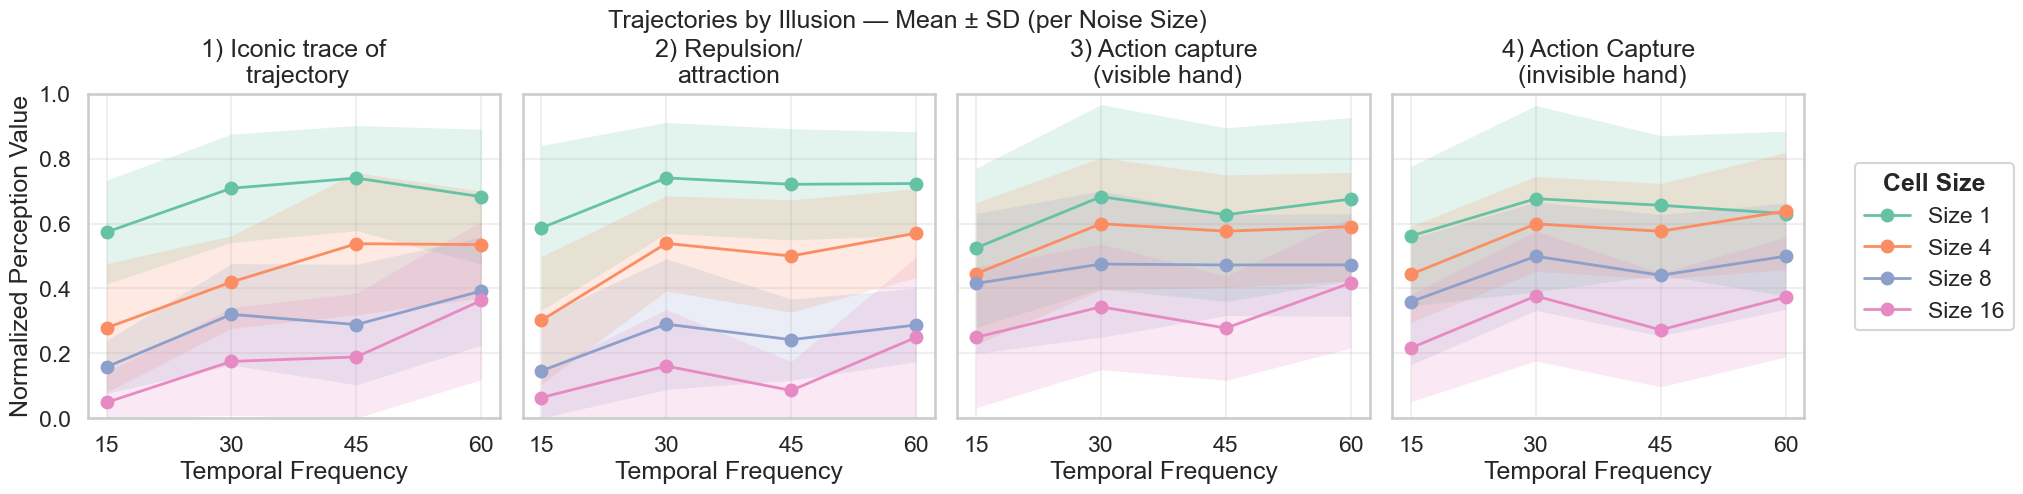

In [5]:
# =========================
# B) Line charts: Mean ± SD vs Temporal Frequency (one line per Noise Size)
# =========================
fig, axes = plt.subplots(
    1, 4, figsize=(18, 4.8),
    sharey=True,
    constrained_layout=True  # <-- use constrained layout
)
palette = sns.color_palette("Set2", n_colors=len(ns_order))

for i, ill in enumerate(illusions):
    mcol, scol = f'{ill} mean', f'{ill} std dev'
    agg = (result_df
           .groupby(['Temporal Frequency', 'Noise Size'], observed=True)[[mcol, scol]]
           .mean()
           .reset_index()
           .sort_values(['Noise Size', 'Temporal Frequency']))

    ax = axes[i]
    for j, ns in enumerate(ns_order):
        sub = agg[agg['Noise Size'] == ns]
        if sub.empty:
            continue
        x = sub['Temporal Frequency'].to_numpy()
        y = sub[mcol].to_numpy()
        s = sub[scol].to_numpy()

        ax.plot(x, y, marker='o', lw=2, label=f'Size {ns}', color=palette[j])
        ylo, yhi = np.clip(y - s, 0, 1), np.clip(y + s, 0, 1)
        ax.fill_between(x, ylo, yhi, alpha=0.18, color=palette[j], linewidth=0)

    ax.set_title(titles[i], pad=8)
    ax.set_xlabel('Temporal Frequency')
    if i == 0:
        ax.set_ylabel('Normalized Perception Value')
    ax.set_ylim(0, 1)
    ax.set_xticks(tf_order)
    ax.grid(True, alpha=0.3)
    
# --- Global legend placed OUTSIDE on the right (no overlap, no warnings) ---
# Remove any accidental per-axis legends
for ax in axes:
    leg = ax.get_legend()
    if leg:
        leg.remove()

handles, labels = axes[0].get_legend_handles_labels()

# With constrained_layout=True, do NOT call subplots_adjust/tight_layout.
# Put the legend at the right and let constrained_layout do the spacing.
legend = fig.legend(
    handles, labels,
    title="Cell Size",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),   # just to the right of the last panel
    ncol=1,
    frameon=True
)
legend.get_title().set_weight("bold")

# Optional: tune padding used by constrained layout (values are inches)
fig.set_constrained_layout_pads(w_pad=2/72, h_pad=2/72, wspace=0.05, hspace=0.05)

# Nice header
fig.suptitle("Trajectories by Illusion — Mean ± SD (per Noise Size)", fontsize=18)
plt.savefig('./Trajectories_by_Illusion.svg', format='svg', bbox_inches='tight')  # Ensure to use bbox_inches
plt.show()


